In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio import plot
from shapely import geometry

from swiss_urban_trees import sample, wms

figwidth, figheight = plt.rcParams["figure.figsize"]
random_seed = 20


def plot_tile_and_trees(ax, img_filepath, trees_gdf, **plot_kwargs):
    """Plot the tile and the trees on top of it."""
    # img = plt.imread(img_filepath)
    with rio.open(img_filepath) as src:
        plot.show(src, ax=ax)
        bounds_geom = geometry.box(*src.bounds)
        trees_gdf[trees_gdf["geometry"].apply(lambda g: g.within(bounds_geom))].plot(
            ax=ax, **plot_kwargs
        )
    ax.axis("off")
    return ax

In [ ]:
# "Inventaire cantonal des arbres pour consultation en ligne" - Manual tree survey
# https://sitg.ge.ch/donnees/sipv-ica-web-public-tot
ica_filepath = "../data/raw/ica-trees.gpkg"

# training data selection parameters
target_genus = ["Platanus", "Tilia", "Acer", "Quercus", "Aesculus"]
# 5% of training data (in terms of tree count of target genus)
train_prop = 0.05

# WMS - "Orthophotos 2019 (pixel 5 cm)" - Imagery
# https://sitg.ge.ch/donnees/image-aerienne-ortho-2019-05
wms_url = (
    "https://raster.sitg.ge.ch/arcgis/services/ORTHOPHOTOS_COLLECTION/MapServer/"
    "WMSServer?request=GetCapabilities&service=WMS"
)
version = "1.3.0"
layer_name = "22"
wms_crs = "EPSG:2056"
res = 0.1  # must be in meters
tile_size = 2000  # in pixels
format = "image/tiff"
nodata = None

# to save data locally
dst_dir = "../data/raw/sitg-multi-species-tiles"
# dst_filepath = "../data/raw/sitg-multi-species-tiles/tiles.gpkg"

In [ ]:
# ICA
ica_gdf = gpd.read_file(ica_filepath)
# filter only aligned trees
ica_gdf = ica_gdf[ica_gdf["TYPE_PLANTATION"] == "Alignement"]
# assign genus
ica_gdf["GENUS"] = ica_gdf["NOM_COMPLET"].str.split().str[0]

In [ ]:
aoi = ica_gdf.union_all().convex_hull
wms_dwd = wms.WMSDownloader(
    wms_url,
    str(layer_name),  # ACHTUNG: ensure layer name is a string
    dst_dir,
    res,
    wms_crs,
    tile_size,
    format,
    nodata=nodata,
    print_func=print,
)
tile_gser = wms_dwd.get_tile_gser(aoi)

In [ ]:
target_genus_gdf = ica_gdf[ica_gdf["GENUS"].isin(target_genus)]
genus_count_ser = target_genus_gdf["GENUS"].value_counts()
genus_count_ser

GENUS
Platanus    1077
Tilia        966
Acer         872
Quercus      589
Aesculus     528
Name: count, dtype: int64

In [ ]:
genus_prop_ser = genus_count_ser / len(ica_gdf.index)
genus_prop_ser.sum()

0.5956566701137539

In [ ]:
tile_to_tree_ser = tile_gser.to_frame().sjoin(target_genus_gdf)["index_right"]
tile_data = [
    (tile_id, df.value_counts().to_dict())
    for tile_id, df in tile_to_tree_ser.map(ica_gdf["GENUS"]).groupby(level=0)
]
# greedy selection of tiles with most balanced occurrences of target genus
selected_tiles, final_counts = sample.select_balanced_tiles(
    tile_data, int(train_prop * genus_count_ser.sum()), target_genus
)
selected_tiles, final_counts

([366, 212, 577, 222, 367, 246],
 {'Platanus': 39.0,
  'Tilia': 65.0,
  'Acer': 41.0,
  'Quercus': 50.0,
  'Aesculus': 37.0})

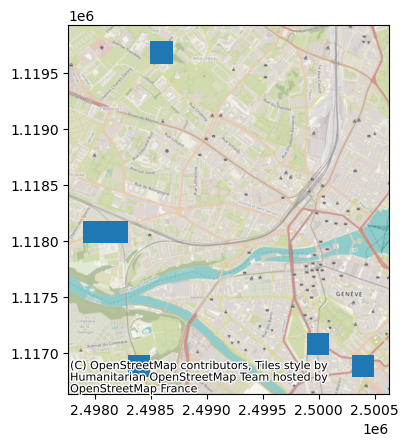

In [ ]:
# plot tile locations
ax = tile_gser.loc[selected_tiles].plot()
cx.add_basemap(ax, crs=wms_crs)

In [ ]:
# download tiles
tile_gdf = wms_dwd.download_tile_gser(tile_gser.loc[selected_tiles])

Splitting the provided AOI into 6 tiles.
Skipping 6 tiles that already exist in ../data/raw/sitg-multi-species-tiles.
No tiles to download.


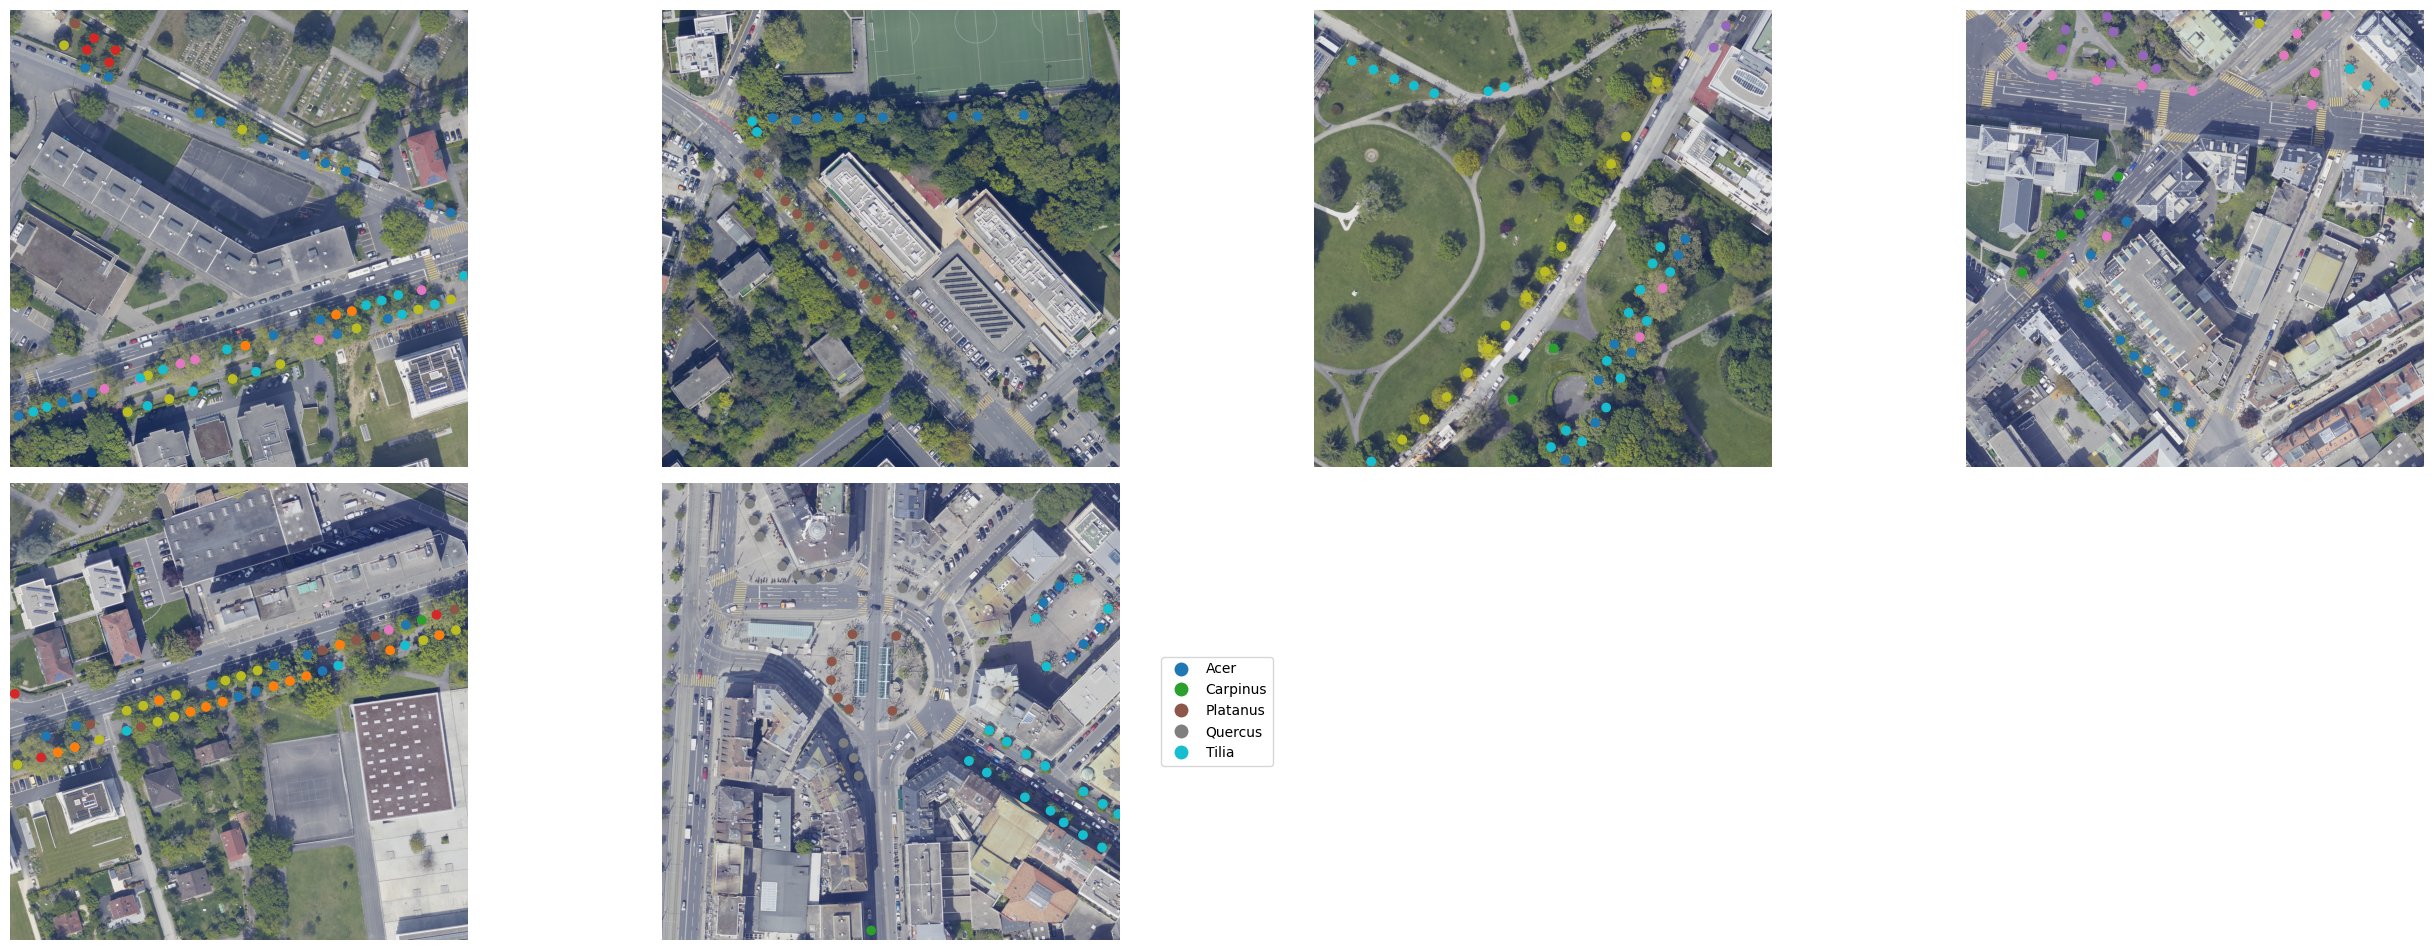

In [ ]:
# plot tiles and point annotations
img_filepaths = tile_gdf["tile_filepath"]
n_imgs = len(img_filepaths)
col_wrap = 4
n_rows = n_imgs // col_wrap
residual = n_imgs % col_wrap
if residual > 0:
    n_rows += 1
fig, axes = plt.subplots(
    n_rows,
    col_wrap,
    figsize=(figwidth * col_wrap, figheight * n_rows),
)
for img_filepath, ax, legend in zip(
    img_filepaths, axes.flat, [False] * (n_imgs - 1) + [True]
):
    plot_tile_and_trees(
        ax,
        img_filepath,
        ica_gdf,
        column="GENUS",
        legend=legend,
        legend_kwds={"loc": "center right", "bbox_to_anchor": (1.35, 0.5)},
    )
for ax in axes.flat[-residual:]:
    fig.delaxes(ax)

fig.tight_layout()